# Load files and cleaning data

In [1]:
import pandas as pd

sheet_cb = "No_Publication_CB_CO2_Detail"
sheet_expansion = "Expansion_Companies_CO2_detail"

usecols_cb = "A:F"
usecols_expansion = "A:H"

df_country_codes = pd.read_csv('../data_sources/longitude-latitude.csv')
df_cb = pd.read_excel('../data_sources/Temp_companies.xlsx', sheet_name=sheet_cb, usecols=usecols_cb)
df_expansion = pd.read_excel('../data_sources/Temp_companies.xlsx', sheet_name=sheet_expansion, usecols=usecols_expansion)
df_cb_april = pd.read_csv(
    '../nb/carbon_bombs_comparison.csv',
    sep=';',
    encoding='utf-8', 
    usecols=['project_name_raw_v2', 'total_emissions_v2'])
df_cb_april = df_cb_april.dropna(how='all')

# Remove last row from df_cb to filter SUM row
df_cb = df_cb.iloc[:-1]
# Remove 2 last rows from df_expansion to filter SUM rows
df_expansion = df_expansion.iloc[:-2]

# Only keep rows from df_april with total_emissions_v2 > 1
df_cb_april = df_cb_april[df_cb_april['total_emissions_v2'] >= 1]

# Fill NaN values in 'project' column with the preceding value
df_cb['Project'] = df_cb['Project'].ffill()
df_expansion['Project'] = df_expansion['Project'].ffill()


# Compare Rystad project differences (disappearance and appearance) for April and June 2025 sources

In [2]:
# Calculate sum for each porject group by project and country
df_cb_june = df_cb.groupby(['Project'])['Total potential emissions (gtCO2)'].sum().reset_index()

# Adjust some names in df_cb_june
df_cb_june['Project'] = df_cb_june['Project'].replace(
    {'Gazprom Dobycha Yamburg, RU': 'Gazprom dobycha Yamburg, RU'}
    )


# Compare df_cb_june and df_cb_april project name to extract those that are not in df_cb_april and vice-versa
df_cb_june_project = df_cb_june['Project'].tolist()
df_cb_april_project = df_cb_april['project_name_raw_v2'].tolist()

# Extract those that are not in df_cb_april and vice-versa
not_in_april = [x for x in df_cb_june_project if x not in df_cb_april_project]
not_in_june = [x for x in df_cb_april_project if x not in df_cb_june_project]

print("Not in April: ", not_in_april)
print("Not in June: ", not_in_june)

# Print shape of df_cb_june and df_cb_april
print("Shape of df_cb_june: ", df_cb_june.shape)
print("Shape of df_cb_april: ", df_cb_april.shape)

# Compare df_db_june and df_cb_april



Not in April:  []
Not in June:  ['Santos Offshore , BR']
Shape of df_cb_june:  (153, 2)
Shape of df_cb_april:  (155, 2)


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Merge April and June data on project names ---
# Rename for clarity before merge
df_cb_april_renamed = df_cb_april.rename(columns={
    'project_name_raw_v2': 'Project',
    'total_emissions_v2': 'April_Emissions'
})

df_cb_june_renamed = df_cb_june.rename(columns={
    'Total potential emissions (gtCO2)': 'June_Emissions'
})

# Inner join to only keep common projects
df_comparison = pd.merge(df_cb_april_renamed, df_cb_june_renamed, on='Project', how='inner')

# Calculate difference and percentage change
df_comparison['Emission_Difference'] = df_comparison['June_Emissions'] - df_comparison['April_Emissions']
df_comparison['Emission_Percent_Change'] = (
    (df_comparison['Emission_Difference'] / df_comparison['April_Emissions']) * 100
)

# --- Basic Stats ---
mean_diff = df_comparison['Emission_Difference'].mean()
median_diff = df_comparison['Emission_Difference'].median()
std_diff = df_comparison['Emission_Difference'].std()
min_diff = df_comparison['Emission_Difference'].min()
max_diff = df_comparison['Emission_Difference'].max()

print("\n--- Emissions Comparison Stats ---")
print(f"Mean Difference: {mean_diff:.3f} GtCO2")
print(f"Median Difference: {median_diff:.3f} GtCO2")
print(f"Standard Deviation: {std_diff:.3f} GtCO2")
print(f"Min Difference: {min_diff:.3f} GtCO2")
print(f"Max Difference: {max_diff:.3f} GtCO2")




--- Emissions Comparison Stats ---
Mean Difference: -0.022 GtCO2
Median Difference: 0.000 GtCO2
Standard Deviation: 0.215 GtCO2
Min Difference: -1.673 GtCO2
Max Difference: 1.324 GtCO2


# Viz 1

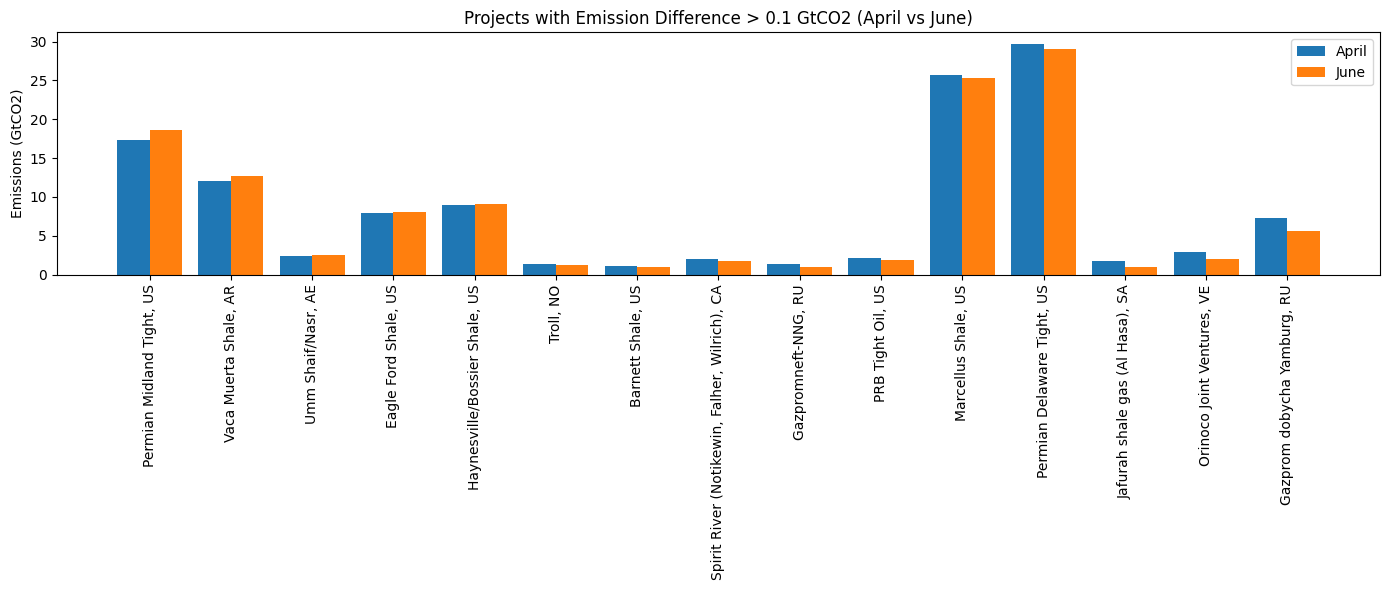

In [4]:
# --- Visualization 1: Bar chart of emissions per project with threshold filter ---
threshold = 0.1  # GtCO2
df_filtered = df_comparison[abs(df_comparison['Emission_Difference']) > threshold]

# Optional: Sort by absolute difference or June emissions
df_plot = df_filtered.sort_values('Emission_Difference', ascending=False)

plt.figure(figsize=(14, 6))
bar_width = 0.4
x = np.arange(len(df_plot))

plt.bar(x - bar_width/2, df_plot['April_Emissions'], width=bar_width, label='April')
plt.bar(x + bar_width/2, df_plot['June_Emissions'], width=bar_width, label='June')
plt.xticks(x, df_plot['Project'], rotation=90)
plt.ylabel('Emissions (GtCO2)')
plt.title(f'Projects with Emission Difference > {threshold} GtCO2 (April vs June)')
plt.legend()
plt.tight_layout()
plt.show()

# Viz 2

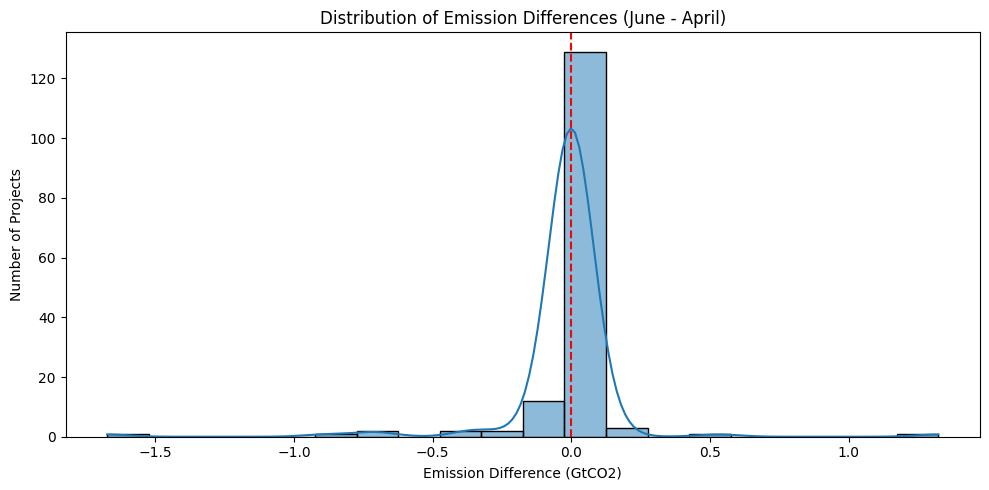

In [5]:
# --- Visualization 2: Distribution of emission differences ---
plt.figure(figsize=(10, 5))
sns.histplot(df_comparison['Emission_Difference'], bins=20, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Emission Differences (June - April)")
plt.xlabel("Emission Difference (GtCO2)")
plt.ylabel("Number of Projects")
plt.tight_layout()
plt.show()

# Viz 3


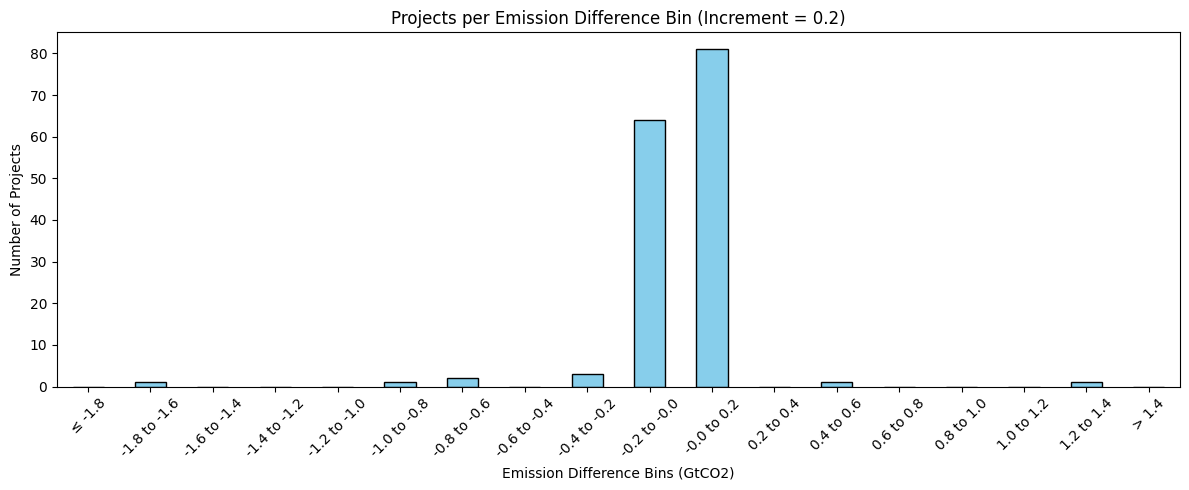

In [6]:
# --- Visualization 3: Custom binned emission difference histogram ---
increment = 0.2

# Determine min and max of differences for bin center range
min_diff = df_comparison['Emission_Difference'].min()
max_diff = df_comparison['Emission_Difference'].max()

# Define internal bin edges from the floor/ceil of min/max
internal_bins = np.arange(
    np.floor(min_diff / increment) * increment,
    np.ceil(max_diff / increment) * increment + increment,
    increment
)

# Add infinite boundaries at start and end
bin_edges = [-np.inf] + list(internal_bins) + [np.inf]

# Create labeled bins
labels = []
for i in range(len(bin_edges)-1):
    left = bin_edges[i]
    right = bin_edges[i+1]
    if left == -np.inf:
        labels.append(f"≤ {right:.1f}")
    elif right == np.inf:
        labels.append(f"> {left:.1f}")
    else:
        labels.append(f"{left:.1f} to {right:.1f}")

# Cut and label
df_comparison['Diff_Bin'] = pd.cut(df_comparison['Emission_Difference'], bins=bin_edges, labels=labels, include_lowest=True)

# Plot histogram of bin counts
plt.figure(figsize=(12, 5))
df_comparison['Diff_Bin'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f"Projects per Emission Difference Bin (Increment = {increment})")
plt.xlabel("Emission Difference Bins (GtCO2)")
plt.ylabel("Number of Projects")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

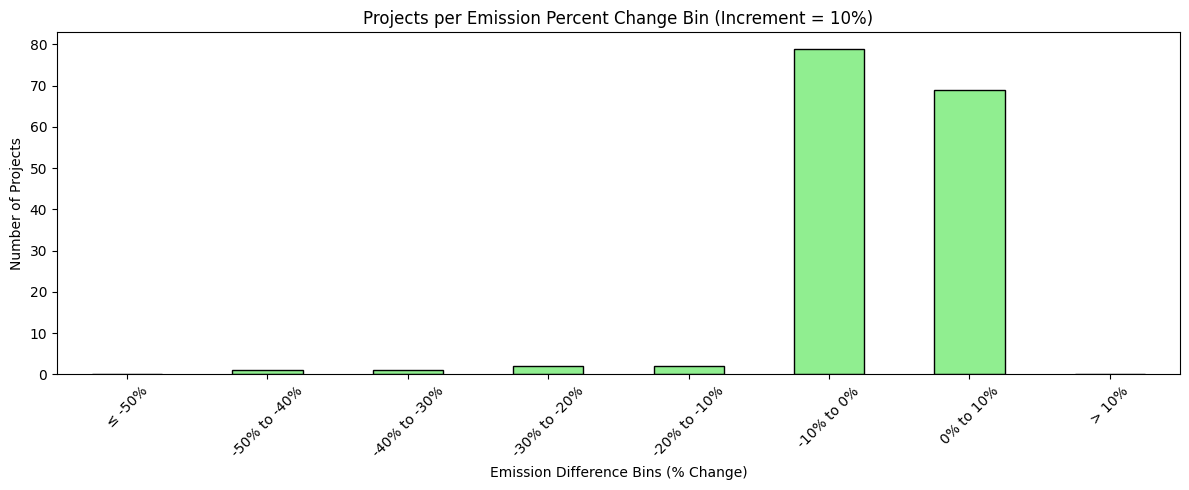

In [7]:
# --- Visualization 4: Emission Difference Histogram by Percentage Change ---
increment_pct = 10  # for 10% bins

# Compute percent change if not already done
df_comparison['Emission_Percent_Change'] = (
    (df_comparison['Emission_Difference'] / df_comparison['April_Emissions']) * 100
)

# Define min and max
min_pct = df_comparison['Emission_Percent_Change'].min()
max_pct = df_comparison['Emission_Percent_Change'].max()

# Internal bins (multiples of 10%)
internal_bins_pct = np.arange(
    np.floor(min_pct / increment_pct) * increment_pct,
    np.ceil(max_pct / increment_pct) * increment_pct + increment_pct,
    increment_pct
)

# Add infinite edges
bin_edges_pct = [-np.inf] + list(internal_bins_pct) + [np.inf]

# Label bins
labels_pct = []
for i in range(len(bin_edges_pct) - 1):
    left = bin_edges_pct[i]
    right = bin_edges_pct[i + 1]
    if left == -np.inf:
        labels_pct.append(f"≤ {right:.0f}%")
    elif right == np.inf:
        labels_pct.append(f"> {left:.0f}%")
    else:
        labels_pct.append(f"{left:.0f}% to {right:.0f}%")

# Bin the data
df_comparison['Percent_Bin'] = pd.cut(df_comparison['Emission_Percent_Change'], bins=bin_edges_pct, labels=labels_pct, include_lowest=True)

# Plot
plt.figure(figsize=(12, 5))
df_comparison['Percent_Bin'].value_counts().sort_index().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title(f"Projects per Emission Percent Change Bin (Increment = {increment_pct}%)")
plt.xlabel("Emission Difference Bins (% Change)")
plt.ylabel("Number of Projects")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Filter for absolute percentage change > 20%
df_abs_above_20 = df_comparison[abs(df_comparison['Emission_Percent_Change']) > 20]

# Display the relevant columns
print("Projects with > 20% absolute change in emissions from April to June:")
print(df_abs_above_20[['Project', 'April_Emissions', 'June_Emissions', 'Emission_Difference', 'Emission_Percent_Change']])


Projects with > 20% absolute change in emissions from April to June:
                             Project  April_Emissions  June_Emissions  \
33       Gazprom dobycha Yamburg, RU         7.231611        5.558407   
71        Orinoco Joint Ventures, VE         2.852887        1.969279   
129              Gazpromneft-NNG, RU         1.348591        1.033385   
134  Jafurah shale gas (Al Hasa), SA         1.729330        1.015713   

     Emission_Difference  Emission_Percent_Change  
33             -1.673204               -23.137368  
71             -0.883608               -30.972427  
129            -0.315205               -23.372942  
134            -0.713617               -41.265526  


In [9]:
# Compare Avril and June extract for Expansion projects
from carbon_bombs.io.rystad import load_rystad_emission_database
from carbon_bombs.conf import SHEETNAME_RYSTAD_GASOIL_EMISSION
import pandas as pd

# Load April dataset
expansion_april = load_rystad_emission_database(SHEETNAME_RYSTAD_GASOIL_EMISSION)

# Assume June dataset is already available as `df_expansion`
expansion_june = df_expansion

# Standardize project columns for comparison
projects_april = expansion_april[['Project_name_raw', 'Total_potential_emissions']].rename(
    columns={'Project_name_raw': 'Project', 'Total_potential_emissions': 'Emissions_April'}
)

projects_june = expansion_june[['Project', 'Potential emissions (mtCO2)']].rename(
    columns={'Potential emissions (mtCO2)': 'Emissions_June'}
)

# Create sets for comparison
set_april = set(projects_april['Project'])
set_june = set(projects_june['Project'])

only_in_june = set_june - set_april
only_in_april = set_april - set_june
in_both = set_april & set_june

print(f"🔹 Projects only in June: {len(only_in_june)}")
print(f"🔹 Projects only in April: {len(only_in_april)}")
print(f"✅ Projects in both datasets: {len(in_both)}")

# Merge datasets on common projects to compare emissions
merged = pd.merge(projects_april, projects_june, on='Project')
merged['Emission_Difference'] = merged['Emissions_June'] - merged['Emissions_April']

# Compute stats on the emission differences
stats = merged['Emission_Difference'].describe()

print("\n📊 Emission difference statistics for common projects:")
print(stats)


🔹 Projects only in June: 151
🔹 Projects only in April: 47
✅ Projects in both datasets: 2045

📊 Emission difference statistics for common projects:
count    4172.000000
mean     -292.101174
std      1039.130579
min     -8284.112594
25%       -38.773990
50%        -7.055702
75%        -0.004553
max       232.080518
Name: Emission_Difference, dtype: float64


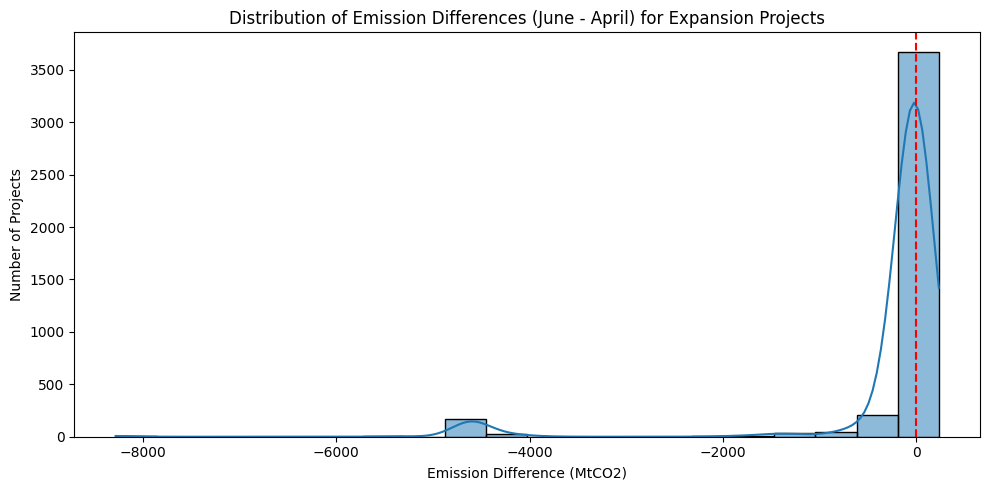

In [10]:
# --- Visualization: Distribution of emission differences ---
plt.figure(figsize=(10, 5))
sns.histplot(merged['Emission_Difference'], bins=20, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Emission Differences (June - April) for Expansion Projects")
plt.xlabel("Emission Difference (MtCO2)")
plt.ylabel("Number of Projects")
plt.tight_layout()
plt.show()